# Finding Lane Lines
[](https://github.com/ndrplz/self-driving-car)

## 1) Import Packages

In [1]:
# import some useful packages
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

## 2) Read in Images

type:  <class 'numpy.ndarray'>
shape:  (540, 960, 3)
data type:  uint8


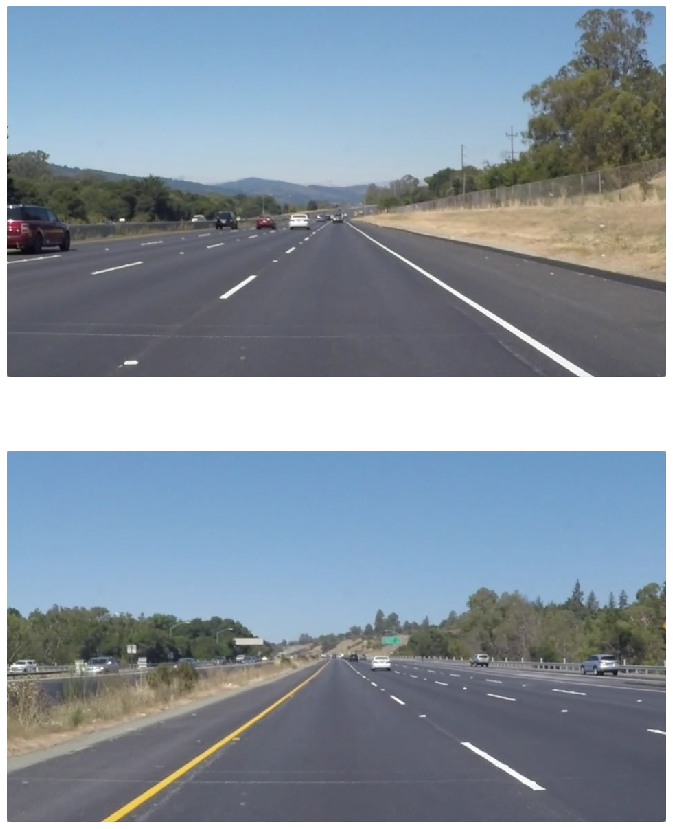

In [2]:
# read in images
img1 = cv2.imread('solidWhiteRight.jpg')
img2 = cv2.imread('solidYellowLeft.jpg')

# print out some stats and plot
print('type: ', type(img1))
print('shape: ', img1.shape)
print('data type: ', img1.dtype)

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2,1,2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## 3) Ideas for Lane Detection Pipeline

**Some OpenCV functions and tutorials that might be useful for this project are:**

`cv2.inRange()` for color selection  

`cv2.fillPoly()` for regions selection  

`cv2.line()` to draw lines on an image given endpoints  

`cv2.addWeighted()` to coadd / overlay two images

`cv2.cvtColor()` to grayscale or change color

`cv2.imwrite()` to output images to file  

`cv2.bitwise_and()` to apply a mask to an image

`cv2.Canny()` Canny function

`cv2.GaussianBlur()` Blurring to reduce noise

`cv2.Sobel()` Sobel function

`cv2.hough()` Hough function

...

https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html
- cv2.canny(), cv2.houghLinesP()

<br>

NOTE : Using these functions is not mandatory.

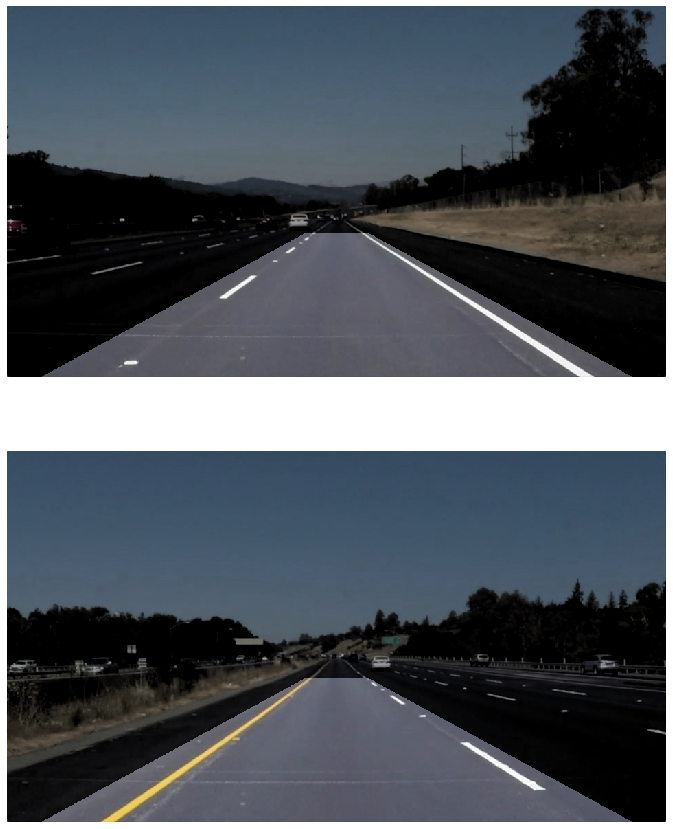

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

plt.figure(figsize=(15,15))

listOfFiles = ['solidWhiteRight.jpg', 'solidYellowLeft.jpg']

for i, file in enumerate(listOfFiles):
    img = cv2.imread(file)
    height, width = img.shape[:2]
    vertices = np.array([[(50, height),
                          (width/2-45, height/2+60), 
                          (width/2+45, height/2+60), 
                          (width-50,height)]], 
                        dtype='int')
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    
    mask = np.zeros(img.shape[:2])
    cv2.fillPoly(mask, vertices, 255)
    
    inv_mask = cv2.bitwise_not(mask.astype('uint8'))
    v = cv2.addWeighted(v, 1.0, inv_mask, -0.4, 0.0)
    
    roi = cv2.merge([h,s,v])
    roi = cv2.cvtColor(roi, cv2.COLOR_HSV2RGB)

    plt.subplot(2,1,i+1)
    plt.imshow(roi)
    plt.axis('off')

plt.show()

## 4) Write your own codes for Lane Detection

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    
    return cv2.bitwise_and(img, mask)

In [108]:
def full_pipeline(img):
    height, width = img.shape[:2]
    #관심역역 설정
    vertices = np.array([[(50, height),
                          (width/2-45, height/2+60), 
                          (width/2+45, height/2+60), 
                          (width-50,height)]],np.int32)
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur_img = cv2.GaussianBlur(gray_img, (3,3), 0)
    canny_img = cv2.Canny(blur_img, 70, 210)
    roi_img = region_of_interest(canny_img, vertices)
    
    #허프변환해서 왼쪽, 오른쪽 차선의 좌표값 저장
    lines =cv2.HoughLinesP(roi_img, 1, 1*np.pi/180, 30, np.array([]), 10, 20)
    
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
    
    #왼쪽, 오른쪽 차선을 구분하여 각각 검출된 양끝 두점을 연결하는 직선의 모든 좌표를 배열에 저장
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1) # 경사 계산
            if slope <= 0: # <-- 경사가 음수이면 왼쪽 차선
                left_line_x.extend([x1, x2])
                left_line_y.extend([y1, y2])
            else: # <-- 양수이면 오른쪽 차선
                right_line_x.extend([x1, x2])
                right_line_y.extend([y1, y2])
                
    #차선의 y값 지정
    min_y = (int)(img.shape[0]*3/5) # 지평선에서
    max_y = img.shape[0] # 이미지 최하단까지
    
    #왼쪽, 오른쪽 차선 각각을 선형방정식으로 연장
    poly_left = np.poly1d(np.polyfit(left_line_y,left_line_x,deg=1))
    left_x_start = int(poly_left(max_y)) # 왼쪽차선방정식과 y=지평선이 만나는 x값 지정
    left_x_end = int(poly_left(min_y)) # 왼쪽차선방정식과 y=최하단이 만나는 x값 지정
    poly_right = np.poly1d(np.polyfit(right_line_y,right_line_x,deg=1))
    right_x_start = int(poly_right(max_y)) # 오른쪽차선방정식과 y=지평선이 만나는 x값 지정
    right_x_end = int(poly_right(min_y))  # 오른쪽차선방정식과 y=최하단이 만나는 x값 지정
    
    
    #원본이미지와 크기가 동인한 빈 이미지 만들기
    img=np.copy(img)
    line_img=np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    #연장된 왼쪽, 오른쪽 차선의 끝점들을 배열로 저장
    lines2 = [[[left_x_start, max_y, left_x_end, min_y],
        [right_x_start, max_y, right_x_end, min_y],
        ]]
    
    #빈이미지에 차선 그리기
    for line in lines2:
        for x1, y1, x2, y2 in line : 
            cv2.line(line_img, (x1, y1), (x2, y2), [0, 0, 255], 5)
            
    #라인이미지와 원본이미지 merge
    result= cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    return result
    

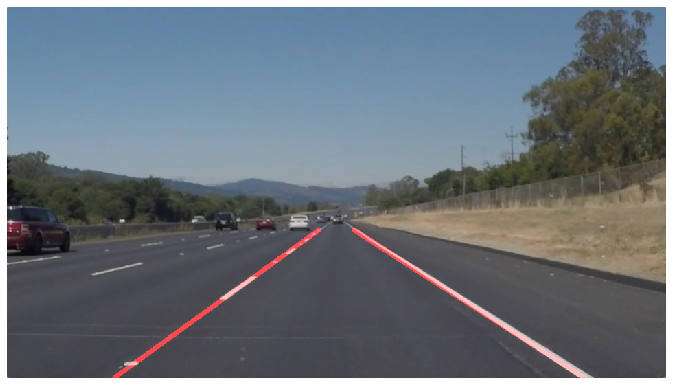

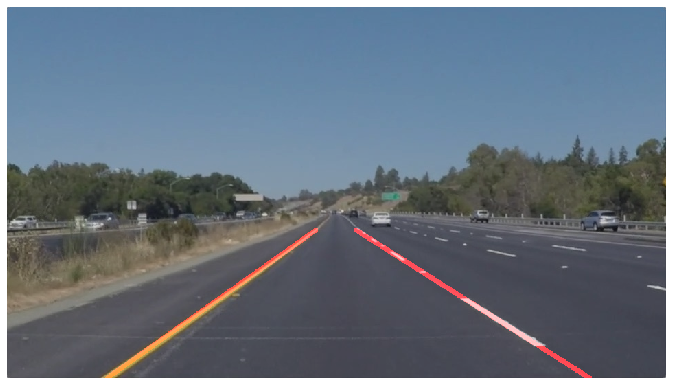

In [118]:
listOfFiles = ['solidWhiteRight.jpg', 'solidYellowLeft.jpg']

for i, file in enumerate(listOfFiles):
    img = cv2.imread(file)
    
    result = full_pipeline(img)
    cv2.imshow('lane detection', result)
    cv2.waitKey(0) 
    
    plt.figure(figsize=(15,15))
    plt.subplot(2,1,i+1)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
        
cv2.destroyAllWindows()

# ※ Further improvements

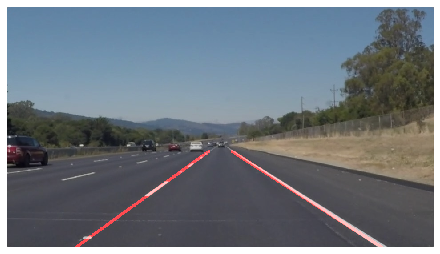

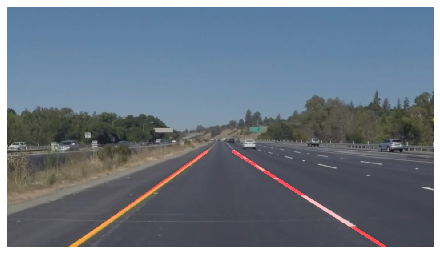

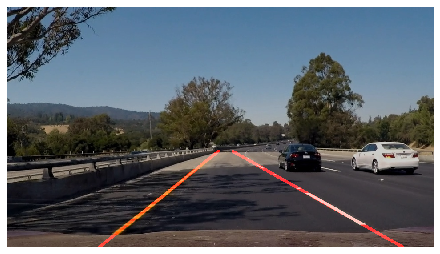

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    
    return cv2.bitwise_and(img, mask)

listOfFiles = ['solidWhiteRight.jpg', 'solidYellowLeft.jpg', 'challenge.jpg']

for i, file in enumerate(listOfFiles):
    img = cv2.imread(file)
    
    result = improved_pipeline(img)
    cv2.imshow('lane detection', result)
    cv2.waitKey(0) 
    
    plt.figure(figsize=(15,15))
    plt.subplot(3,1,i+1)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
cv2.destroyAllWindows()

In [7]:
def improved_pipeline(img):
    '''
    1. 기울기 얼마 이상인 것만 차선으로 보는 필터링
    2. 차선당 하나의 직선으로 표현
    '''
    height, width = img.shape[:2]
    #관심역역 설정
    vertices = np.array([[(50, height),
                          (width/2-45, height/2+60), 
                          (width/2+45, height/2+60), 
                          (width-50,height)]],np.int32)
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur_img = cv2.GaussianBlur(gray_img, (3,3), 0)
    canny_img = cv2.Canny(blur_img, 70, 210)
    roi_img = region_of_interest(canny_img, vertices)
    
    #허프변환해서 왼쪽, 오른쪽 차선의 좌표값 저장
    lines =cv2.HoughLinesP(roi_img, 1, 1*np.pi/180, 30, np.array([]), 10, 20)
    
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
    
    #왼쪽, 오른쪽 차선을 구분하여 각각 검출된 양끝 두점을 연결하는 직선의 모든 좌표를 배열에 저장
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1) # 경사 계산
            if math.fabs(slope) < 0.5: # 가장 큰 경사만 고려
                continue
            if slope <= 0: # <-- 경사가 음수이면 왼쪽 차선
                left_line_x.extend([x1, x2])
                left_line_y.extend([y1, y2])
            else: # <-- 양수이면 오른쪽 차선
                right_line_x.extend([x1, x2])
                right_line_y.extend([y1, y2])
                
    #차선의 y값 지정
    min_y = (int)(img.shape[0]*3/5) # 지평선에서
    max_y = img.shape[0] # 이미지 최하단까지
    
    #왼쪽, 오른쪽 차선 각각을 선형방정식으로 연장
    poly_left = np.poly1d(np.polyfit(left_line_y,left_line_x,deg=1))
    left_x_start = int(poly_left(max_y)) # 왼쪽차선방정식과 y=지평선이 만나는 x값 지정
    left_x_end = int(poly_left(min_y)) # 왼쪽차선방정식과 y=최하단이 만나는 x값 지정
    poly_right = np.poly1d(np.polyfit(right_line_y,right_line_x,deg=1))
    right_x_start = int(poly_right(max_y)) # 오른쪽차선방정식과 y=지평선이 만나는 x값 지정
    right_x_end = int(poly_right(min_y))  # 오른쪽차선방정식과 y=최하단이 만나는 x값 지정
    
    
    #원본이미지와 크기가 동인한 빈 이미지 만들기
    img=np.copy(img)
    line_img=np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    #연장된 왼쪽, 오른쪽 차선의 끝점들을 배열로 저장
    lines2 = [[[left_x_start, max_y, left_x_end, min_y],
        [right_x_start, max_y, right_x_end, min_y],
        ]]
    
    #빈이미지에 차선 그리기
    for line in lines2:
        for x1, y1, x2, y2 in line : 
            cv2.line(line_img, (x1, y1), (x2, y2), [0, 0, 255], 5)
            
    #라인이미지와 원본이미지 merge
    result= cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    return result
    
    return result
    